# Neural Network Classifier (BERT-Boosted) x Toxic Content Detection
Il presente Notebook mostra l'addestramento ed il testing di un Classificatore basato su Neural network per il task di Toxic Content Detection.

I dati sono stati processati come segue:
1. Pulizia del testo (si veda 'dataset_preprocessing.py')
2. Estrazione delle Features mediante BERT (si veda 'feature_extraction_bert_windows.ipynb'/'feature_extraction_bert_mac.ipynb')

In [1]:
import pandas as pd
import numpy as np
import pickle
import nltk
import re
import torch
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertModel
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense,Reshape
from tensorflow.keras.optimizers.legacy import Adam as Adam_legacy
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

C:\Users\Riccardo De Cesaris\AppData\Local\Temp\ipykernel_47256\1753812017.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
e:\anaconda3\envs\DL_GPU_Full\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All'interno del Notebook saranno addestrate due Reti Neurali, una sul Dataset "non-Lemmatizzato" e l'altra sul Dataset "Lemmatizzato".

In [2]:
# Verifica il dispositivo attualmente utilizzato da TensorFlow
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('GPU disponibile, TensorFlow sta utilizzando la GPU.')
else:
    print('GPU non disponibile, TensorFlow sta utilizzando la CPU.')

GPU disponibile, TensorFlow sta utilizzando la GPU.


## Funzioni di Supporto

In [3]:
# Carica il tokenizer e il modello preaddestrato di BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [4]:
# Definizione di una funzione per estrarre le caratteristiche di un testo utilizzando BERT
def extract_features(strings):
    # return_tensors ritorna il tensore per la versione pytorch
    # padding = true fa in modo che frasi di lunghezza diversa vengono portate alla lunghezza massima
    inputs = tokenizer(strings, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    #rappresentazione media e unidimensionale delle caratteristiche estratte
    features = torch.mean(last_hidden_states, dim=1).squeeze()
    features = features.numpy()
    return pd.DataFrame(features)

# Neural Network

## Addestramento

In [5]:
training_set = pd.read_csv("./../../datasets/training_set.csv")
print("Numero di Frasi nel Training Set:", len(training_set))
print("Numero Frasi 'toxic' nel Training Set:", len(training_set[training_set['toxic'] == 1]))
print("Numero Frasi 'not-toxic' nel Training Set:", len(training_set[training_set['toxic'] == 0]))

Numero di Frasi nel Training Set: 15282
Numero Frasi 'toxic' nel Training Set: 3058
Numero Frasi 'not-toxic' nel Training Set: 12224


In [6]:
y_train = training_set['toxic']

In [7]:
X_train = pd.read_csv("./../../datasets/X_train_bert.csv")
print("X_train.shape", X_train.shape)

X_train.shape (15282, 768)


In [8]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train.shape[1],), dtype='float'),
        tf.keras.layers.Reshape((X_train.shape[1],1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, padding='same', activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, padding='same'),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, padding='same'),
        tf.keras.layers.Conv1D(filters=16, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.Conv1D(filters=8, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.Conv1D(filters=4, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(140, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ]
)

In [9]:
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 768, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 384, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 192, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 192, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 96, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 16)            2

In [ ]:
X_train = X_train.to_numpy()

# Addestramento sul Dataset non-lemmatizzato
print("Training della Rete Neurale sul Dataset 'non-Lemmatizzato'...")
start = datetime.now()
model.fit(X_train, y_train,epochs=10, batch_size=32)
end = datetime.now()
print("Training completato! Tempo impiegato: " + str(end-start))

model.save("neural_classifier_big.h5")

In [10]:
model = tf.keras.models.load_model("neural_classifier_big.h5")

## Testing

In [11]:
test_data = pd.read_csv("./../../datasets/test_set.csv")
test_data.dropna(inplace=True)

test_set = test_data[test_data['toxic'] != -1]
exp_set = test_data[test_data['toxic'] == -1]

print("Numero di Frasi nel Test Set:", len(test_set))
print("Numero Frasi 'toxic' nel Test Set:", len(test_set[test_set['toxic'] == 1]))
print("Numero Frasi 'not-toxic' nel Test Set:", len(test_set[test_set['toxic'] == 0]))

Numero di Frasi nel Test Set: 63842
Numero Frasi 'toxic' nel Test Set: 6087
Numero Frasi 'not-toxic' nel Test Set: 57755


In [12]:
X_test = pd.read_csv("./../../datasets/X_test_bert.csv")
print("X_test.shape:", X_test.shape)
y_test = test_set['toxic']

X_test.shape: (63842, 768)


In [13]:
i = 0
predictions = list()
while i < X_test.shape[0]:
    to_submit = X_test[i:i+2500]
    to_test = to_submit.to_numpy()
    y_pred = model.predict(to_test)
    predictions.append(y_pred)
    i += 2500

    del to_submit
    del to_test
    del y_pred

42/42 [==============================] - 0s 5ms/step


In [14]:
y_pred = np.concatenate(predictions)
y_pred.shape
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

In [15]:
#Metriche: Accuracy,Precision,Recall
print("Accuracy: " + str(accuracy_score(y_test, y_pred_binary)))
print("Precision: " + str(precision_score(y_test, y_pred_binary)))
print("Recall: " + str(recall_score(y_test, y_pred_binary)))
print("F-Measure: " + str(f1_score(y_test, y_pred_binary)))

Accuracy: 0.9032768396980044
Precision: 0.49483568075117373
Recall: 0.6926236241169705
F-Measure: 0.577257479290751


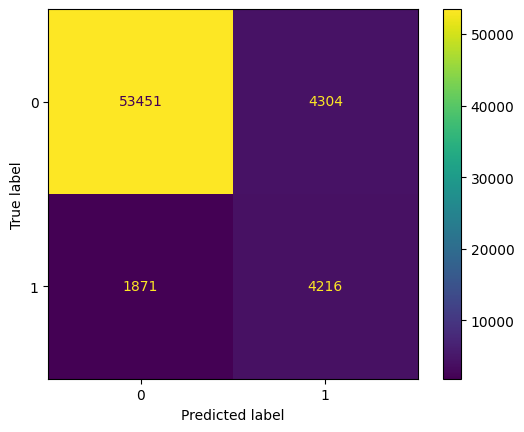

In [16]:
cm = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

In [17]:
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

ROC-AUC Score: 0.9262464387297241
